In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, utils, Model, regularizers 
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, 
    MaxPooling2D, Dropout, Dense, Add, GlobalAveragePooling2D, Flatten
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc, classification_report
)

print("TensorFlow:", tf.__version__)
print("TFP:", tfp.__version__)






TensorFlow: 2.19.0
TFP: 0.25.0


In [3]:
# DANECHKA я ебал этот куда, просто комментируй этот блок
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Включаем оптимизации oneDNN (важно для Intel)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

# Для 12-го поколения особенно важно включить Intel DL Boost
os.environ['TF_ENABLE_MKL_NATIVE_FORMAT'] = '1'

def configure_cpu_optimization():
    physical_cores = os.cpu_count() // 2
    logical_cores = os.cpu_count()
    
    tf.config.threading.set_intra_op_parallelism_threads(logical_cores)
    tf.config.threading.set_inter_op_parallelism_threads(physical_cores)
    
    tf.config.optimizer.set_jit(True)
    tf.config.set_soft_device_placement(True)

    # itex.set_backend('cpu', throughput_mode=True)

configure_cpu_optimization()

In [40]:
# Путь к вашей папке с неразложенными файлами
# src_dir = r".\ieee-ai-and-ml-demystified\train\train"

# # Перебираем все файлы в папке
# for filename in os.listdir(src_dir):
#     if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # только изображения
#         continue
#     # Определяем класс по имени файла (до первой точки)
#     class_name = filename.split('.')[0]  # 'cat' или 'dog'
#     class_dir = os.path.join(src_dir, class_name)
#     # Создаём папку, если её нет
#     if not os.path.exists(class_dir):
#         os.makedirs(class_dir)
#     # Перемещаем файл
#     shutil.move(
#         os.path.join(src_dir, filename),
#         os.path.join(class_dir, filename)
#     )
# print("Готово! Все файлы разложены по папкам.")


In [5]:
# пайплайн
def build_data_pipeline(
    train_dir, 
    test_dir, 
    img_size=(32, 32), 
    batch_size=32, 
    val_split=0.2
):
    # Загрузка тренировочных и валидационных данных
    train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='binary',
        color_mode='grayscale',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True,
        seed=42,
        validation_split=val_split,
        subset='both'
    )
    
    # Загрузка тестовых данных
    test_ds = load_test_data(test_dir, img_size)
    
    # Нормализация данных
    rescale = layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (rescale(x), y), 
                          num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (rescale(x), y), 
                      num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.map(lambda x, file_name: (rescale(x), file_name),
                        num_parallel_calls=tf.data.AUTOTUNE)
    
    # Оптимизация производительности
    train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

def load_test_data(test_dir, img_size):
    # Создаем датасет из файлов изображений
    file_paths = tf.data.Dataset.list_files(test_dir + "/*.jpg", shuffle=False)
    
    def process_file(file_path):
        # Загрузка и обработка изображения
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32)
        
        # Получаем имя файла для последующей идентификации
        file_name = tf.strings.split(file_path, os.sep)[-1]
        
        return img, file_name
    
    # Применяем функцию к каждому файлу
    test_ds = file_paths.map(process_file, num_parallel_calls=tf.data.AUTOTUNE)
    
    return test_ds

def visualize_dataset(dataset, title, show_filenames=False):
    plt.figure(figsize=(10, 10))
    for images, labels_or_filenames in dataset.take(1):
        for i in range(min(9, images.shape[0])):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            
            if show_filenames:
                # Для тестового датасета показываем имена файлов
                plt.title(f"File: {labels_or_filenames[i].numpy().decode('utf-8')}")
            else:
                # Для train/val показываем метки
                plt.title(f"Label: {labels_or_filenames[i].numpy()}")
                
            plt.axis('off')
    plt.suptitle(title)
    plt.show()


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.

Структура датасетов:
Train: (TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
Val: (TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))
Test: (TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))


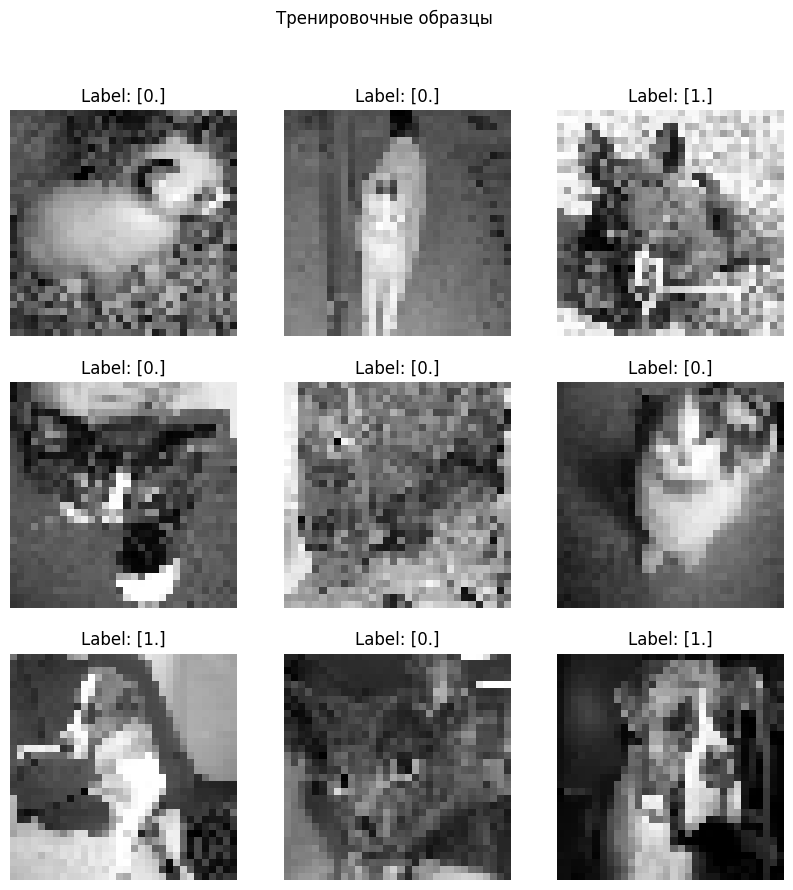

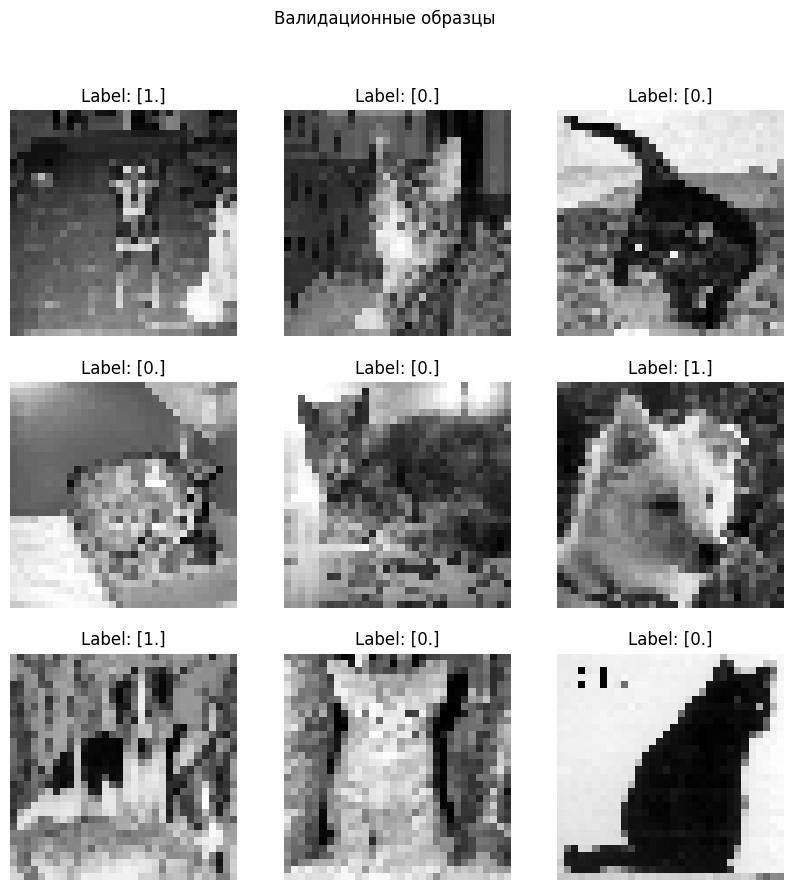

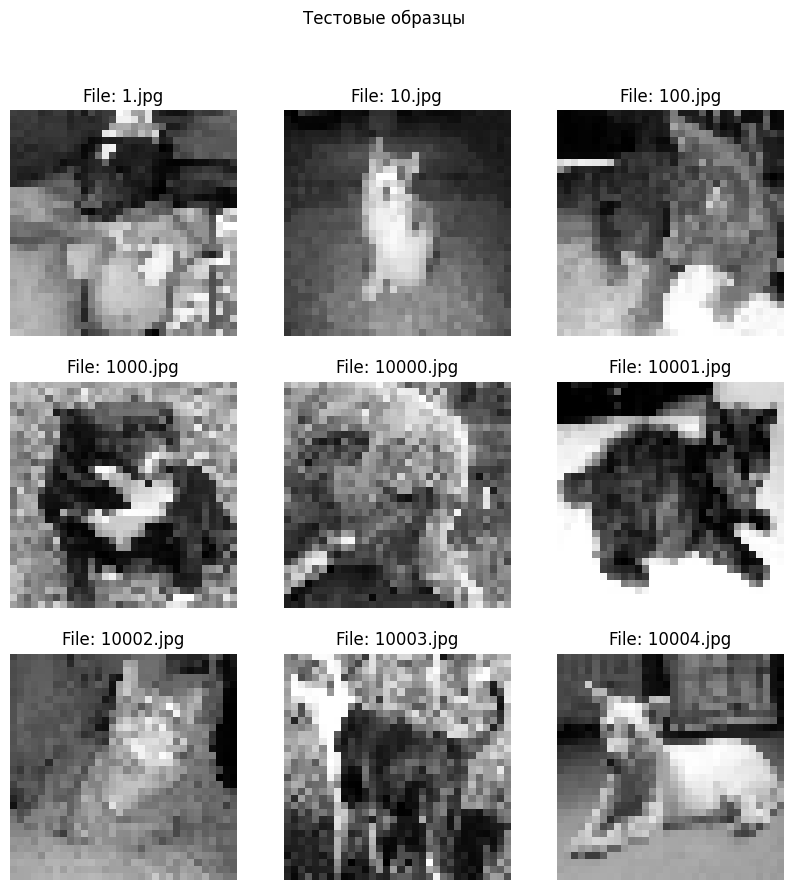

In [6]:
train_ds, val_ds, test_ds = build_data_pipeline(
    train_dir="./ieee-ai-and-ml-demystified/train/train",
    test_dir="./ieee-ai-and-ml-demystified/test1/test1",
    img_size=(32, 32),
    batch_size=32
)

# Проверка структуры данных
print("\nСтруктура датасетов:")
print(f"Train: {train_ds.element_spec}")
print(f"Val: {val_ds.element_spec}")
print(f"Test: {test_ds.element_spec}")

# Визуализация образцов из каждого датасета
visualize_dataset(train_ds, "Тренировочные образцы") 
visualize_dataset(val_ds, "Валидационные образцы")
visualize_dataset(test_ds, "Тестовые образцы", show_filenames=True)


Оригинальный размер: 625
Фиксированный аугментированный размер: 1250 (x2 увеличение)


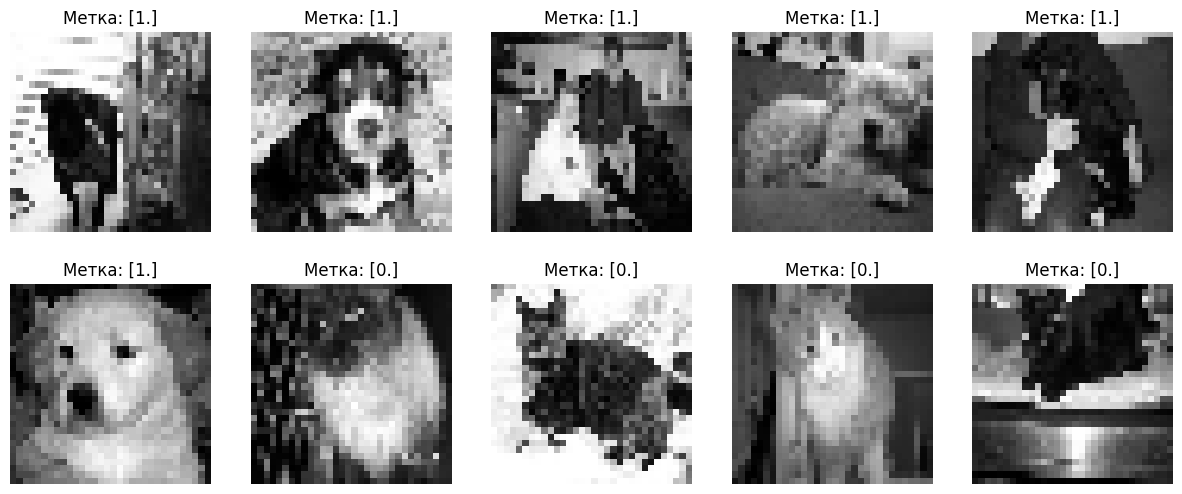

In [43]:
def add_advanced_augmentation(train_ds, val_ds, test_ds, num_augmented_copies=1):
    # Создаем слои аугментации
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomZoom(0.1),
        layers.RandomBrightness(0.1),
        layers.RandomContrast(0.1),
    ])

    # Создаем фиксированные аугментированные данные
    augmented_datasets = []
    for _ in range(num_augmented_copies):
        # Применяем аугментацию и кэшируем результат
        aug_ds = train_ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        ).cache()  # Фиксируем аугментированные данные
        augmented_datasets.append(aug_ds)

    # Объединяем все датасеты (оригинальный + аугментированные копии)
    combined_train_ds = train_ds
    for aug_ds in augmented_datasets:
        combined_train_ds = combined_train_ds.concatenate(aug_ds)

    return combined_train_ds, val_ds, test_ds


# Создаем датасет с 1 аугментированной копией (в 2 раза больше оригинального)
train_ds_final, val_ds, test_ds = add_advanced_augmentation(
    train_ds, 
    val_ds, 
    test_ds, 
    num_augmented_copies=1  # Можно увеличить до 3-5
)

# Проверяем размер
original_size = len(list(train_ds))
final_size = len(list(train_ds_final))
print(f"Оригинальный размер: {original_size}")
print(f"Фиксированный аугментированный размер: {final_size} (x{final_size // original_size} увеличение)")

# Получаем батч из объединенного датасета
combined_images, combined_labels = next(iter(train_ds_final))

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(combined_images[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Метка: {combined_labels[i].numpy()}")
    plt.axis('off')
plt.show()



Оригинальный размер: 625
Новый размер: 1250 (x2 увеличение)


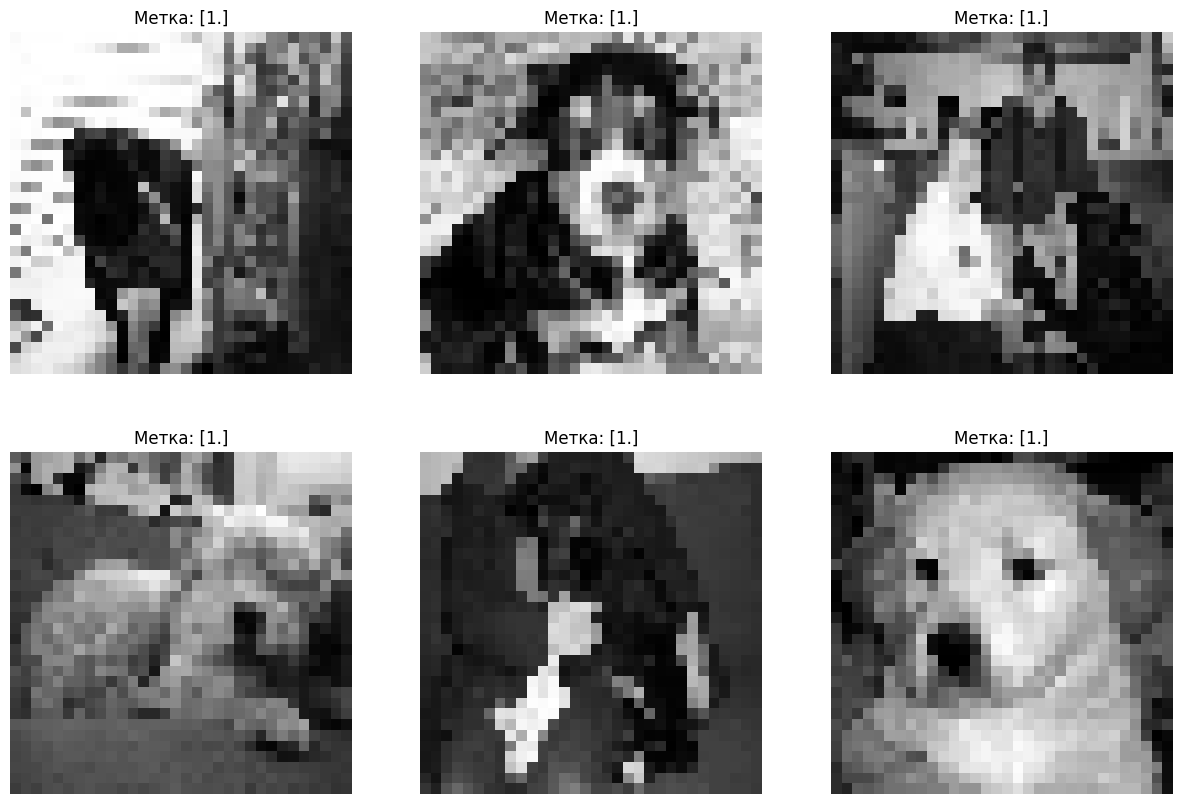

In [44]:
def add_gaussian_noise(image, mean=0.0, stddev=0.01):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=image.dtype)
    return image + noise

def apply_noise_regularization(train_ds, val_ds, test_ds, num_noisy_copies=1):
    # Создаем зашумленные копии
    noisy_datasets = []
    for _ in range(num_noisy_copies):
        noisy_ds = train_ds.map(
            lambda x, y: (add_gaussian_noise(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        ).cache()  # Фиксируем шум для воспроизводимости
        noisy_datasets.append(noisy_ds)
    
    # Объединяем все датасеты
    combined_train_ds = train_ds
    for ds in noisy_datasets:
        combined_train_ds = combined_train_ds.concatenate(ds)
    
    return combined_train_ds, val_ds, test_ds

train_ds_noisy, val_ds, test_ds = apply_noise_regularization(
    train_ds, 
    val_ds, 
    test_ds, 
    num_noisy_copies=1  # Можно увеличить до 2-3
)

# Проверяем размер
print(f"Оригинальный размер: {len(list(train_ds))}")
print(f"Новый размер: {len(list(train_ds_noisy))} (x{len(list(train_ds_noisy))//len(list(train_ds))} увеличение)")

# Получаем примеры из объединенного датасета
combined_images, combined_labels = next(iter(train_ds_noisy))

plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(combined_images[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Метка: {combined_labels[i].numpy()}")
    plt.axis('off')
plt.show()


In [45]:
def analyze_class_distribution(train_ds):
    # Подсчитываем количество образцов каждого класса
    class_counts = {0: 0, 1: 0}
    
    for _, labels_batch in train_ds:
        # Обрабатываем весь батч сразу
        labels_np = labels_batch.numpy().flatten()  # Приводим к плоскому массиву
        for label in labels_np:
            label_int = int(label)
            if label_int in class_counts:
                class_counts[label_int] += 1
    
    total = sum(class_counts.values())
    print("Распределение классов:")
    for cls, count in class_counts.items():
        print(f"Класс {cls}: {count} образцов ({count/total:.2%})")
    
    # Вычисляем веса классов
    class_weights = {
        cls: total / (len(class_counts) * count) 
        for cls, count in class_counts.items()
    }
    
        # Построение графика распределения классов
    plt.figure(figsize=(6, 4))
    plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])
    plt.xticks([0, 1], ['Класс 0', 'Класс 1'])
    plt.xlabel('Класс')
    plt.ylabel('Количество образцов')
    plt.title('Распределение классов в тренировочном наборе')
    plt.show()

    return class_weights



Распределение классов:
Класс 0: 40152 образцов (50.19%)
Класс 1: 39848 образцов (49.81%)


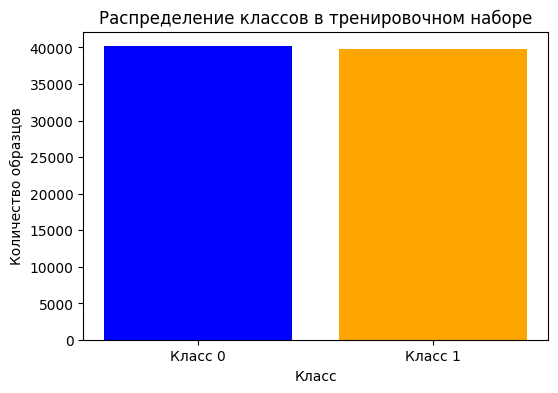

Сводка модели:


Model: "functional_63"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │        320 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32,    │      9,248 │ activation_21[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │      9,248 │ activation_22[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 32, 32,    │          0 │ activation_21[0]… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 32, 32,    │          0 │ add_9[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ activation_23[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 16, 16,    │     18,496 │ dropout_9[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 16, 16,    │      2,112 │ dropout_9[0][0] 

 Total params: 2,407,489 (9.18 MB)

 Trainable params: 2,405,633 (9.18 MB)

 Non-trainable params: 1,856 (7.25 KB)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 311s 123ms/step - accuracy: 0.5943 - loss: 1.5021 - precision: 0.5912 - recall: 0.5966 - val_accuracy: 0.7442 - val_loss: 0.7254 - val_precision: 0.8375 - val_recall: 0.6154 - learning_rate: 0.0010
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 295s 118ms/step - accuracy: 0.7017 - loss: 0.6960 - precision: 0.7034 - recall: 0.6926 - val_accuracy: 0.7574 - val_loss: 0.6977 - val_precision: 0.6912 - val_recall: 0.9437 - learning_rate: 0.0010
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 296s 118ms/step - accuracy: 0.7324 - loss: 0.6253 - precision: 0.7307 - recall: 0.7315 - val_accuracy: 0.7856 - val_loss: 0.6022 - val_precision: 0.8744 - val_recall: 0.6745 - learning_rate: 0.0010
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 295s 118ms/step - accuracy: 0.7531 - loss: 0.5831 - precision: 0.7514 - recall: 0.7522 - val_accuracy: 0.8092 - val_loss: 0.5531 - val_precision: 0.9045 - val_recall: 0.6978 - learning_rate: 0.0010
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━

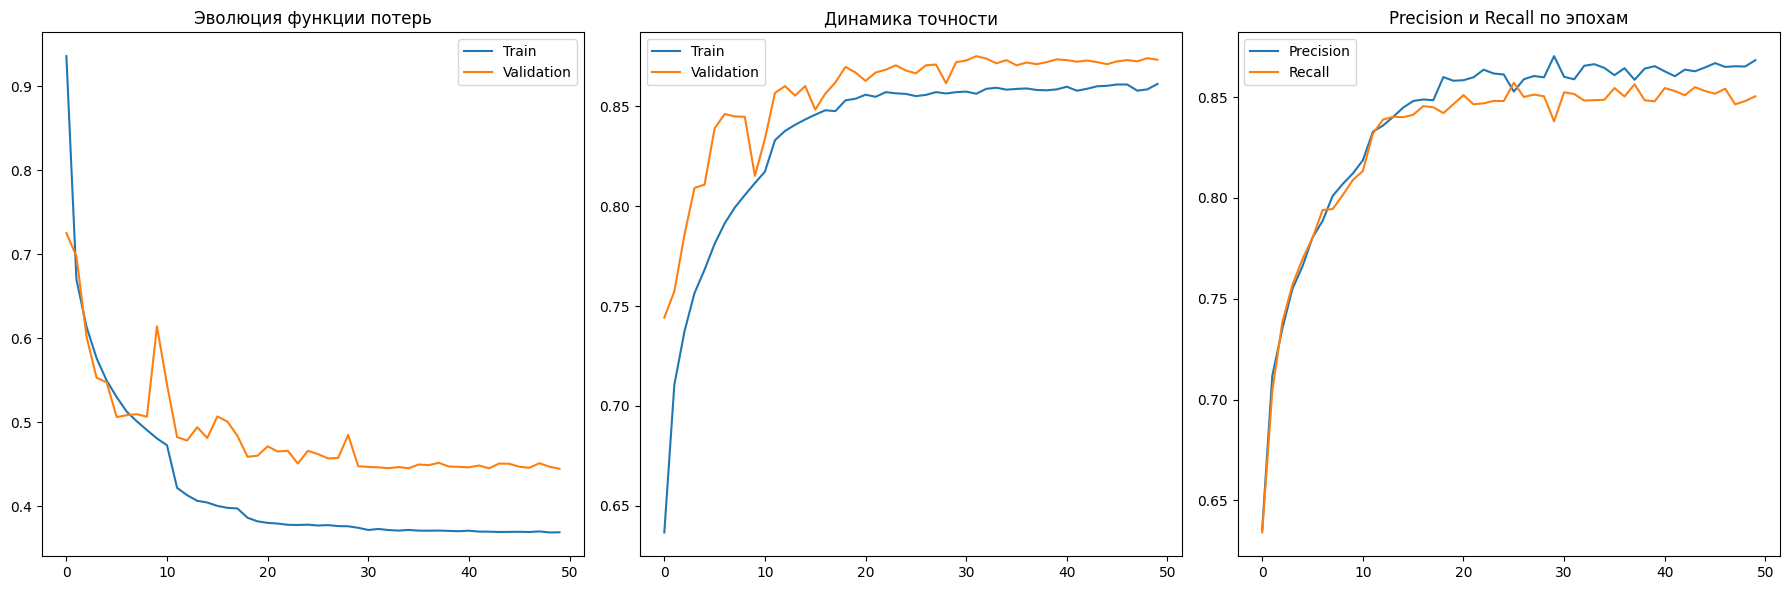

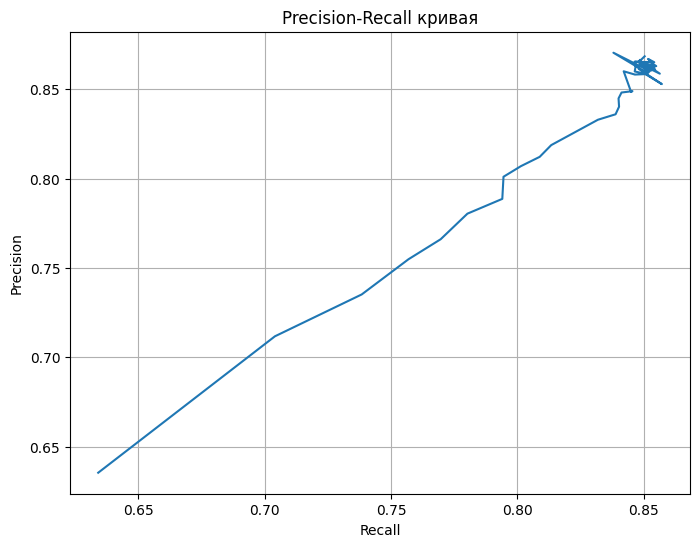

Модель успешно сохранена!


In [46]:
# Определение residual блока (оставляем как есть)
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([shortcut, x])
    return Activation('relu')(x)

# Полная архитектура модели (оставляем как есть)
inputs = Input(shape=(32, 32, 1))
x = Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Блок 1
x = residual_block(x, 32)
x = MaxPooling2D(2)(x)
x = Dropout(0.3)(x)

# Блок 2
x = residual_block(x, 64)  # Автоматическая проекция
x = MaxPooling2D(2)(x)
x = Dropout(0.4)(x)

# Блок 3
x = residual_block(x, 128)  # Автоматическая проекция
x = Flatten()(x)

# Полносвязные слои
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Подготовка улучшенных датасетов с аугментацией и шумом
# Используя функции, которые мы определили ранее
train_ds_final, val_ds, test_ds = add_advanced_augmentation(
    train_ds, 
    val_ds, 
    test_ds, 
    num_augmented_copies=1  # Можно увеличить до 3-5
)
train_ds_noisy, val_ds, test_ds = apply_noise_regularization(
    train_ds, 
    val_ds, 
    test_ds, 
    num_noisy_copies=1  # Можно увеличить до 2-3
)

combined_train_ds = train_ds_final.concatenate(train_ds_noisy)

# Преобразуем компоненты к согласованным размерностям
aligned_ds = combined_train_ds.map(
    lambda x, y: (x, tf.reshape(y, [-1])),  # Преобразуем метки к форме [batch_size]
    num_parallel_calls=tf.data.AUTOTUNE
)

# Теперь можно безопасно использовать unbatch
class_weights = analyze_class_distribution(aligned_ds.unbatch())

# Компиляция модели
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


print("Сводка модели:")
model.summary()

# Модифицированное обучение модели
history = model.fit(
    combined_train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,  # Добавляем веса классов
    callbacks=[
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            verbose=1,
            min_lr=0.00001
        )

    ],
    verbose=1
)

# Исправленная визуализация результатов
def plot_advanced_metrics(history):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1,3,1)
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='Train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='Validation')
    plt.title('Эволюция функции потерь')
    
    plt.subplot(1,3,2)
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='Train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='Validation')
    plt.title('Динамика точности')
    
    plt.subplot(1,3,3)
    # Исправляем построение precision-recall
    plt.plot(history.history['precision'], label='Precision')
    plt.plot(history.history['recall'], label='Recall')
    plt.legend()
    plt.title('Precision и Recall по эпохам')
    
    plt.tight_layout()
    plt.show()

    # Дополнительный график: Precision-Recall кривая
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['recall'], history.history['precision'])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall кривая')
    plt.grid(True)
    plt.show()

# Визуализация метрик
plot_advanced_metrics(history)

# Сохранение модели
model.save('cat_dog_classifier_pro.keras')
print("Модель успешно сохранена!")


391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step
Первые 5 предсказаний: [1, 0, 1, 1, 1]


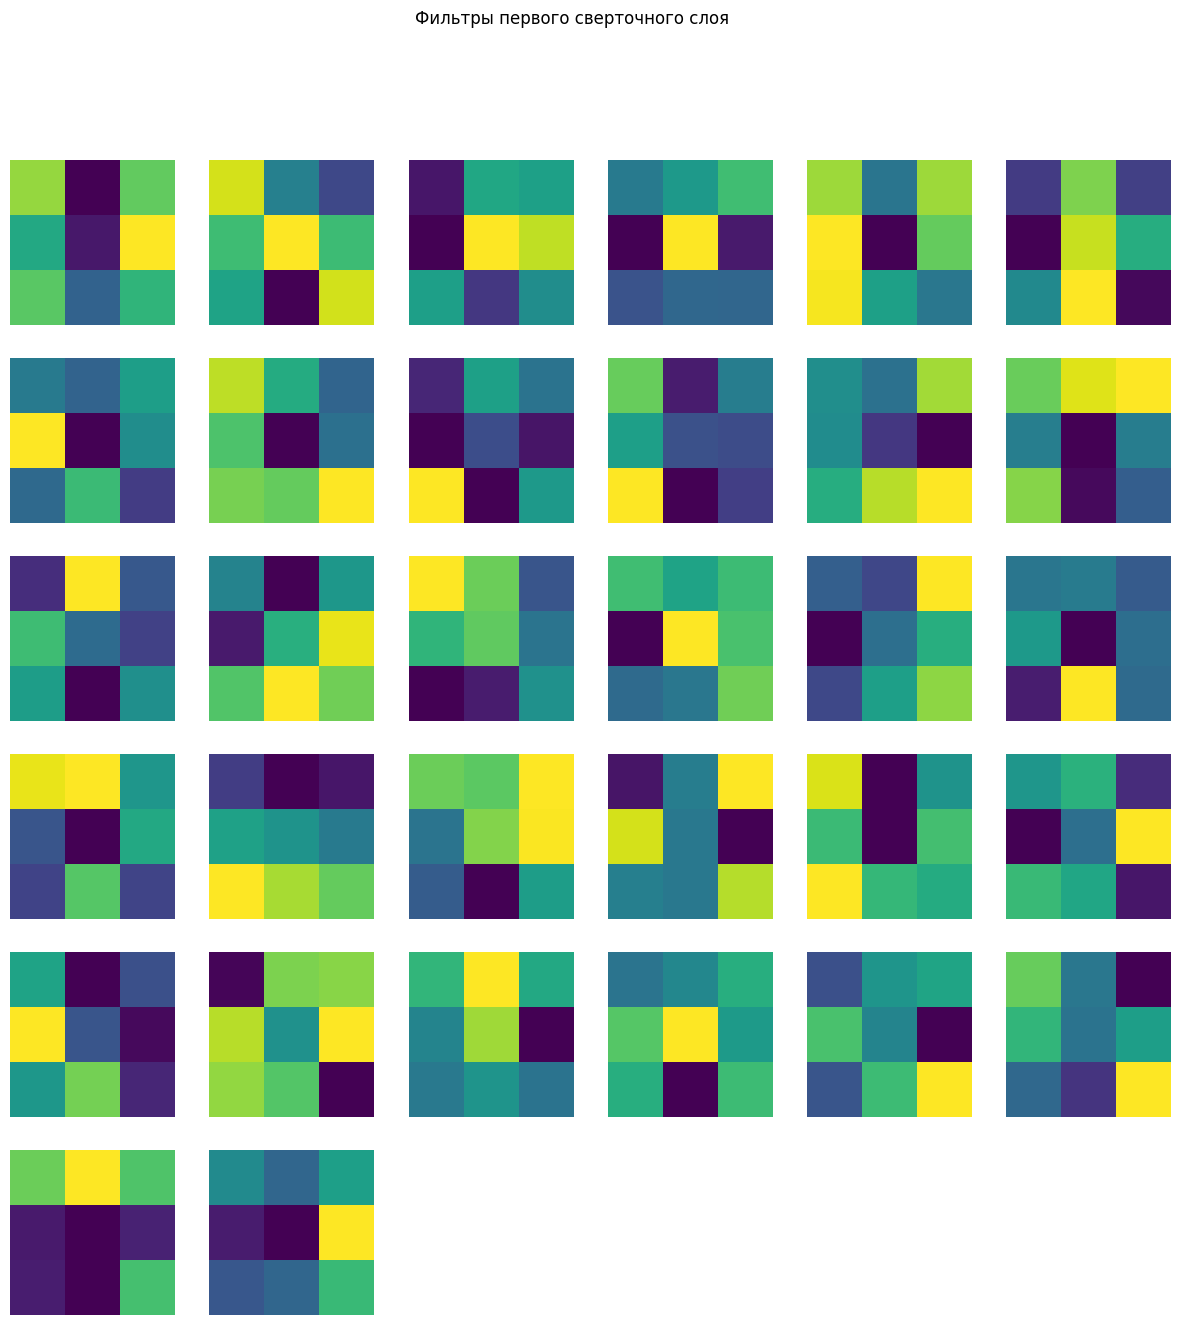

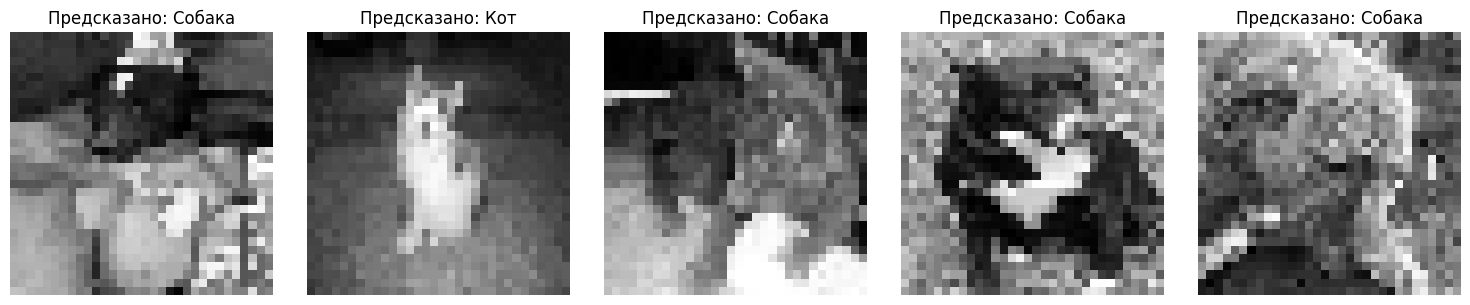

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


<Figure size 800x600 with 0 Axes>

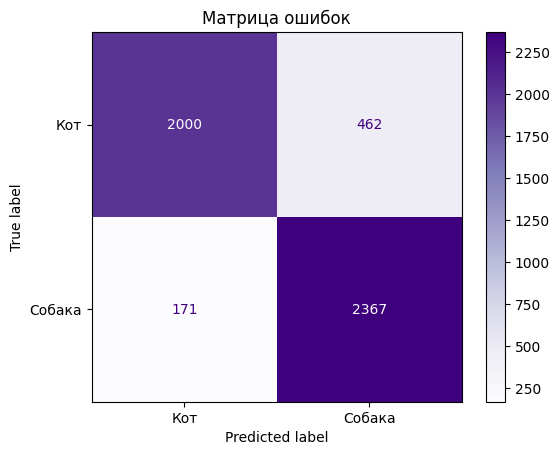

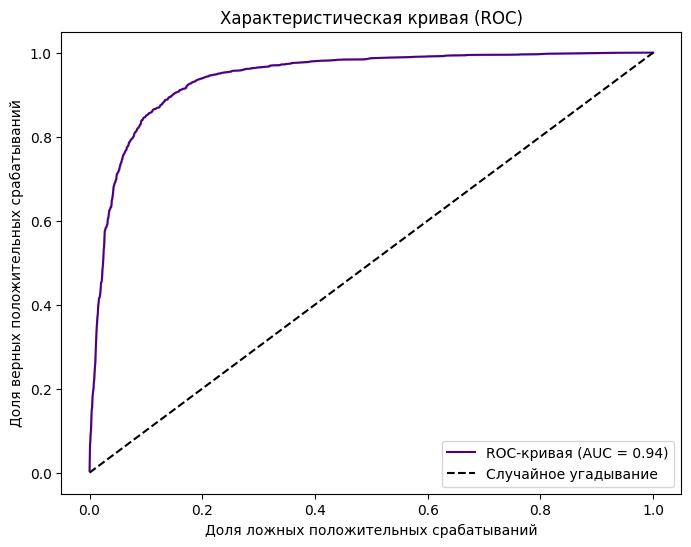

              precision    recall  f1-score   support

         Кот       0.92      0.81      0.86      2462
      Собака       0.84      0.93      0.88      2538

    accuracy                           0.87      5000
   macro avg       0.88      0.87      0.87      5000
weighted avg       0.88      0.87      0.87      5000



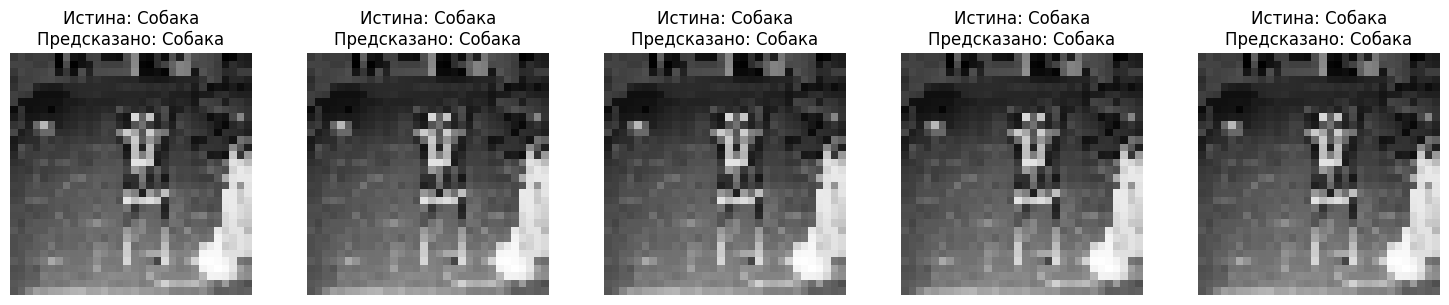

In [15]:
# Загрузка модели
model = tf.keras.models.load_model("./cat_dog_classifier_pro.keras")

# Подготовка тестовых данных
X_test = []
id_line = []
def create_test1_data(path1):
    for p in os.listdir(path1):
        id_line.append(p.split(".")[0])
        img_array = cv2.imread(os.path.join(path1,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(32, 32))
        X_test.append(new_img_array)
        
# Исправлен путь (убран двойной слеш)
create_test1_data("./ieee-ai-and-ml-demystified/test1/test1")
X_test = np.array(X_test).reshape(-1,32,32,1)
X_test = X_test/255.0  # Явное приведение к float

# Получение предсказаний
predictions = model.predict(X_test)

# Обработка предсказаний в зависимости от их формы
if len(predictions.shape) > 1 and predictions.shape[1] == 1:
    predicted_val = [int(round(p[0])) for p in predictions]
else:
    predicted_val = [int(round(p)) for p in predictions]

print("Первые 5 предсказаний:", predicted_val[0:5])

# Создание файла с предсказаниями
submission_df = pd.DataFrame({'id':id_line, 'label':predicted_val}) 
submission_df.to_csv("submission123.csv", index=False)

# Визуализация фильтров первого сверточного слоя
try:
    # Поиск первого сверточного слоя
    conv_layers = [layer for layer in model.layers if 'conv2d' in layer.name.lower()]
    if conv_layers:
        first_conv = conv_layers[0]
        filters, biases = first_conv.get_weights()
        n_filters = filters.shape[-1]
        
        plt.figure(figsize=(15, 15))
        rows = int(np.ceil(np.sqrt(n_filters)))
        cols = int(np.ceil(n_filters / rows))
        
        for i in range(min(n_filters, rows*cols)):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(filters[:, :, 0, i], cmap='viridis')
            plt.axis('off')
        plt.suptitle('Фильтры первого сверточного слоя')
        plt.show()
except Exception as e:
    print(f"Ошибка при визуализации фильтров: {e}")

# Визуализация предсказаний модели на тестовых данных
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i].reshape(32, 32), cmap='gray')
    plt.title(f'Предсказано: {"Собака" if predicted_val[i] == 1 else "Кот"}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Блок для анализа на размеченных данных (если они доступны)
try:
    # Проверка наличия валидационных данных
    X_val = []
    y_val = []
    
    # Сбор данных из валидационного датасета
    for images, labels in val_ds:
        for i in range(len(images)):
            X_val.append(images[i].numpy())
            y_val.append(labels[i].numpy())
    
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    
    # Получение предсказаний
    val_preds = model.predict(X_val)
    y_pred = (val_preds > 0.5).astype("int32").flatten()
    
    # Построение матрицы ошибок
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Кот', 'Собака'])
    plt.figure(figsize=(8, 6))
    disp.plot(cmap='Purples')
    plt.title('Матрица ошибок')
    plt.show()
    
    # Вычисление ROC-кривой
    fpr, tpr, thresholds = roc_curve(y_val, val_preds.flatten())
    roc_auc = auc(fpr, tpr)
    
    # Построение ROC-кривой
    plt.figure(figsize=(8, 6))
    sns.lineplot(x=fpr, y=tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})', color='indigo')
    plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')
    plt.title('Характеристическая кривая (ROC)')
    plt.xlabel('Доля ложных положительных срабатываний')
    plt.ylabel('Доля верных положительных срабатываний')
    plt.legend()
    plt.show()
    
    # Отчет по классификации
    print(classification_report(y_val, y_pred, target_names=['Кот', 'Собака']))
    
    # Визуализация ошибок
    errors = np.where(y_val != y_pred)[0]
    if len(errors) > 0:
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(errors[:min(5, len(errors))]):
            plt.subplot(1, min(5, len(errors)), i+1)
            plt.imshow(X_val[idx].reshape(32, 32), cmap='gray')
            plt.title(f'Истина: {"Собака" if y_val[idx] == 1 else "Кот"}\nПредсказано: {"Собака" if y_pred[idx] == 1 else "Кот"}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("Ошибок в валидационных данных не обнаружено")
        
except NameError:
    print("Валидационные данные недоступны. Пропускаем анализ с метриками.")


In [16]:
from flask import Flask, request, render_template_string, jsonify
import io
from PIL import Image
import numpy as np
import cv2
import os

# Убедитесь, что модель уже загружена
# model = tf.keras.models.load_model("./cat_dog_classifier_pro.keras")

# Создание Flask-приложения для интерфейса
app = Flask(__name__)

# HTML шаблон в виде строки (для удобства использования без отдельного файла)
html_template = """
<!DOCTYPE html>
<html>
<head>
    <title>Классификатор кошек и собак</title>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        body {
            font-family: Arial, sans-serif;
            max-width: 800px;
            margin: 0 auto;
            padding: 20px;
            background-color: #f5f5f5;
        }
        h1 {
            color: #333;
            text-align: center;
        }
        .upload-form {
            border: 2px dashed #ccc;
            padding: 30px;
            text-align: center;
            margin-bottom: 20px;
            background-color: white;
            border-radius: 10px;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        }
        #preview {
            max-width: 300px;
            margin: 20px auto;
        }
        #predictBtn {
            background-color: #4CAF50;
            color: white;
            padding: 10px 20px;
            border: none;
            border-radius: 4px;
            cursor: pointer;
            font-size: 16px;
            transition: background-color 0.3s;
        }
        #predictBtn:disabled {
            background-color: #cccccc;
            cursor: not-allowed;
        }
        #predictBtn:hover:not([disabled]) {
            background-color: #45a049;
        }
        .result {
            padding: 15px;
            border-radius: 5px;
            margin-top: 20px;
            text-align: center;
            font-weight: bold;
            font-size: 18px;
            background-color: white;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        }
        #imageInput {
            margin: 10px 0;
        }
    </style>
</head>
<body>
    <h1>Классификатор кошек и собак</h1>
    <div class="upload-form">
        <h2>Загрузите изображение</h2>
        <input type="file" id="imageInput" accept="image/*">
        <div id="preview"></div>
        <button id="predictBtn" disabled>Определить</button>
    </div>
    <div id="result" class="result" style="display: none;"></div>

    <script>
        const imageInput = document.getElementById('imageInput');
        const previewDiv = document.getElementById('preview');
        const predictBtn = document.getElementById('predictBtn');
        const resultDiv = document.getElementById('result');

        imageInput.addEventListener('change', function() {
            const file = this.files[0];
            if (file) {
                const reader = new FileReader();
                reader.onload = function(e) {
                    previewDiv.innerHTML = `<img src="${e.target.result}" style="max-width: 100%;">`;
                    predictBtn.disabled = false;
                    resultDiv.style.display = 'none'; // Скрыть предыдущий результат
                }
                reader.readAsDataURL(file);
            }
        });

        predictBtn.addEventListener('click', function() {
            const file = imageInput.files[0];
            if (!file) return;

            const formData = new FormData();
            formData.append('file', file);
            
            resultDiv.style.display = 'block';
            resultDiv.innerHTML = 'Обработка...';
            predictBtn.disabled = true;
            
            fetch('/predict', {
                method: 'POST',
                body: formData
            })
            .then(response => response.json())
            .then(data => {
                if (data.error) {
                    resultDiv.innerHTML = `Ошибка: ${data.error}`;
                } else {
                    resultDiv.innerHTML = `Результат: ${data.result} (уверенность: ${data.confidence})`;
                }
                predictBtn.disabled = false;
            })
            .catch(error => {
                resultDiv.innerHTML = `Ошибка: ${error.message}`;
                predictBtn.disabled = false;
            });
        });
    </script>
</body>
</html>
"""

@app.route('/')
def index():
    return render_template_string(html_template)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        if 'file' not in request.files:
            return jsonify({'error': 'Файл не найден'})
        
        file = request.files['file']
        if file.filename == '':
            return jsonify({'error': 'Файл не выбран'})
        
        # Чтение и обработка изображения
        in_memory_file = io.BytesIO()
        file.save(in_memory_file)
        in_memory_file.seek(0)
        
        try:
            image = np.array(Image.open(in_memory_file).convert('RGB'))
        except Exception as e:
            return jsonify({'error': f'Ошибка обработки изображения: {str(e)}'})
        
        # Преобразуем в оттенки серого
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Изменяем размер до 32x32
        resized = cv2.resize(gray, (32, 32))
        
        # Нормализуем значения пикселей
        normalized = resized / 255.0
        
        # Преобразуем форму для модели
        processed_image = np.expand_dims(normalized, axis=[0, -1])
        
        # Получение предсказания
        prediction = model.predict(processed_image)[0][0]
        result = "Собака" if prediction > 0.5 else "Кошка"
        confidence = float(prediction) if prediction > 0.5 else float(1 - prediction)
        
        return jsonify({
            'result': result,
            'confidence': f"{confidence * 100:.2f}%"
        })
    except Exception as e:
        return jsonify({'error': f'Произошла ошибка: {str(e)}'})

# Для запуска в Jupyter Notebook или другой среде
if __name__ == '__main__':
    # Убедимся, что модель загружена
    if 'model' not in globals():
        try:
            import tensorflow as tf
            model = tf.keras.models.load_model("./cat_dog_classifier_pro.keras")
            print("Модель успешно загружена")
        except Exception as e:
            print(f"Ошибка загрузки модели: {e}")
            exit(1)
    
    app.run(debug=True, use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [12/May/2025 23:16:55] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


127.0.0.1 - - [12/May/2025 23:17:12] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


127.0.0.1 - - [12/May/2025 23:17:48] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


127.0.0.1 - - [12/May/2025 23:18:18] "POST /predict HTTP/1.1" 200 -
